# **Download Dataset**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d warcoder/tyre-quality-classification

 99% 2.65G/2.66G [00:32<00:00, 99.7MB/s]
100% 2.66G/2.66G [00:32<00:00, 87.5MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/tyre-quality-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# **Import Library**

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

base_dir = "/content/Digital images of defective and good condition tyres"

In [ ]:
print(base_dir)

/content/Digital images of defective and good condition tyres


# **Data Preparation**

In [ ]:
list(sorted(os.listdir(base_dir)))

['defective', 'good']

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1856 files belonging to 2 classes.
Using 1485 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1856 files belonging to 2 classes.
Using 371 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['defective', 'good']


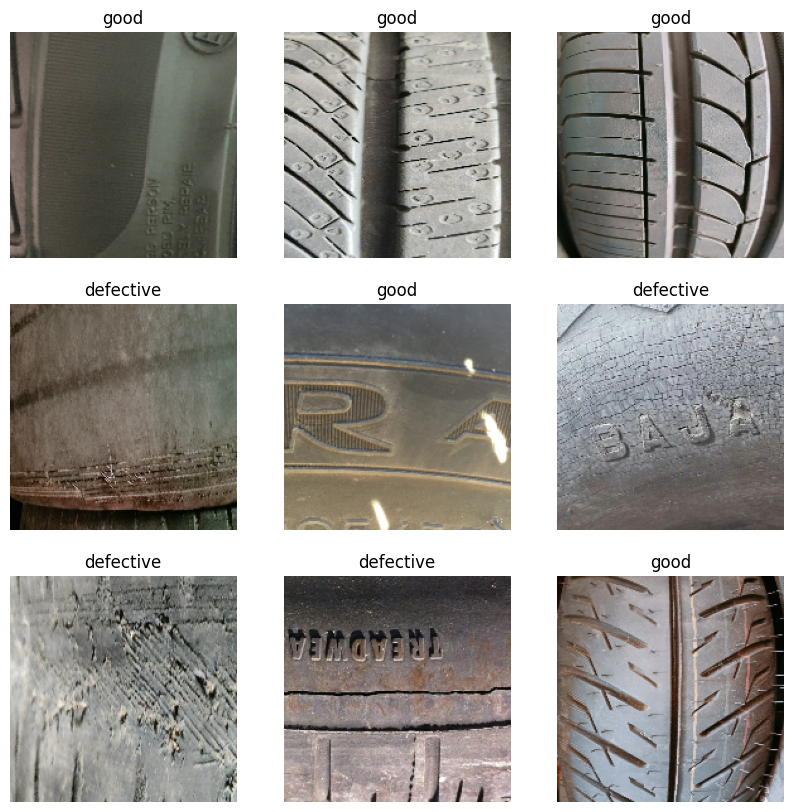

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.026740968 1.0


# **Membuat Model / Sequential**

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
learning_rate_reduction=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience=2,factor=0.5, min_lr=0.00001,verbose =1)
Early_Stopping= tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5, restore_best_weights=True)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
   callbacks=[Early_Stopping,learning_rate_reduction],
  epochs=epochs
)

Epoch 1/10
47/47 [==============================] - 64s 1s/step - loss: 0.6849 - accuracy: 0.5859 - val_loss: 0.6254 - val_accuracy: 0.6685 - lr: 0.0010
Epoch 2/10
47/47 [==============================] - 47s 992ms/step - loss: 0.6078 - accuracy: 0.6835 - val_loss: 0.5689 - val_accuracy: 0.7224 - lr: 0.0010
Epoch 3/10
47/47 [==============================] - 47s 998ms/step - loss: 0.5710 - accuracy: 0.7172 - val_loss: 0.5565 - val_accuracy: 0.7412 - lr: 0.0010
Epoch 4/10
47/47 [==============================] - 47s 1s/step - loss: 0.5400 - accuracy: 0.7333 - val_loss: 0.5709 - val_accuracy: 0.7062 - lr: 0.0010
Epoch 5/10
47/47 [==============================] - ETA: 0s - loss: 0.4978 - accuracy: 0.7623
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
47/47 [==============================] - 47s 1s/step - loss: 0.4978 - accuracy: 0.7623 - val_loss: 0.6122 - val_accuracy: 0.6846 - lr: 0.0010
Epoch 6/10
47/47 [==============================] - 45s 958ms/step - l

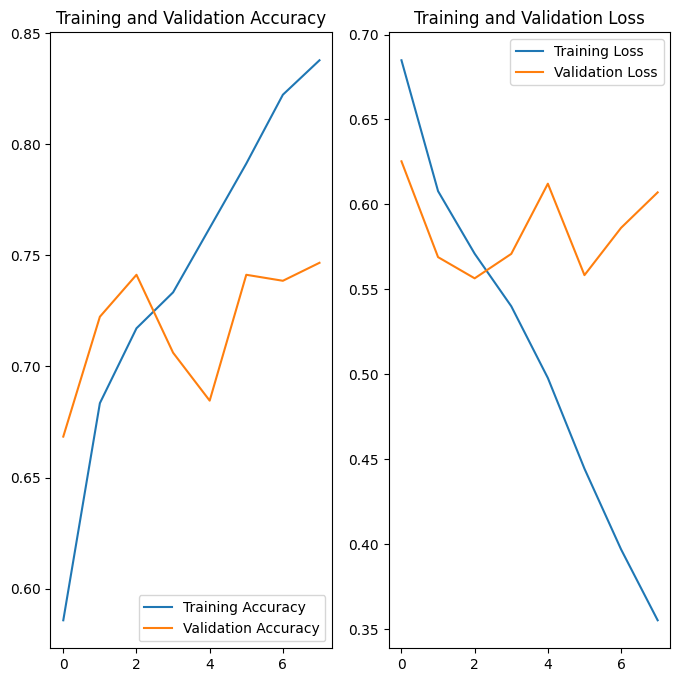

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(8)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy=model.evaluate(val_ds)
print(f"Accuracy:{accuracy}")
print(f"Loss:{loss}")

12/12 [==============================] - 4s 372ms/step - loss: 0.5565 - accuracy: 0.7412
Accuracy:0.7412399053573608
Loss:0.5564684867858887


Karena akurasi training dan validasi jauh, hal itu meng-indikasikan adanya overfitting. Maka akan dilakukan penyesuaian dengan augmentasi dan drop out

# **Augmentasi**

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# **Drop Out**

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu', strides=1),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu',strides=1),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu',strides=1),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# **Compile ulang**

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

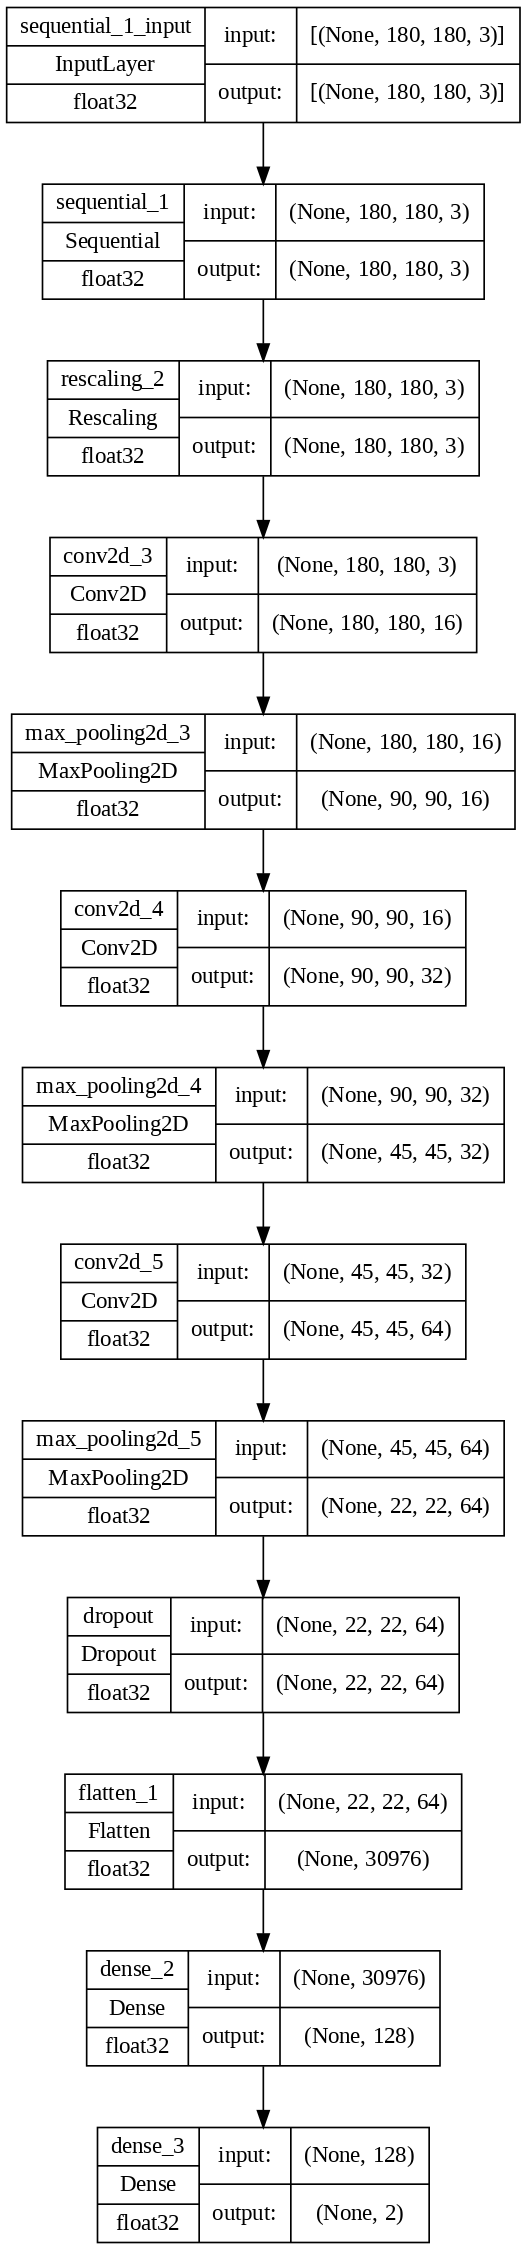

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, show_dtype=True, dpi=120)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 7.5 MB/s eta 0:00:00


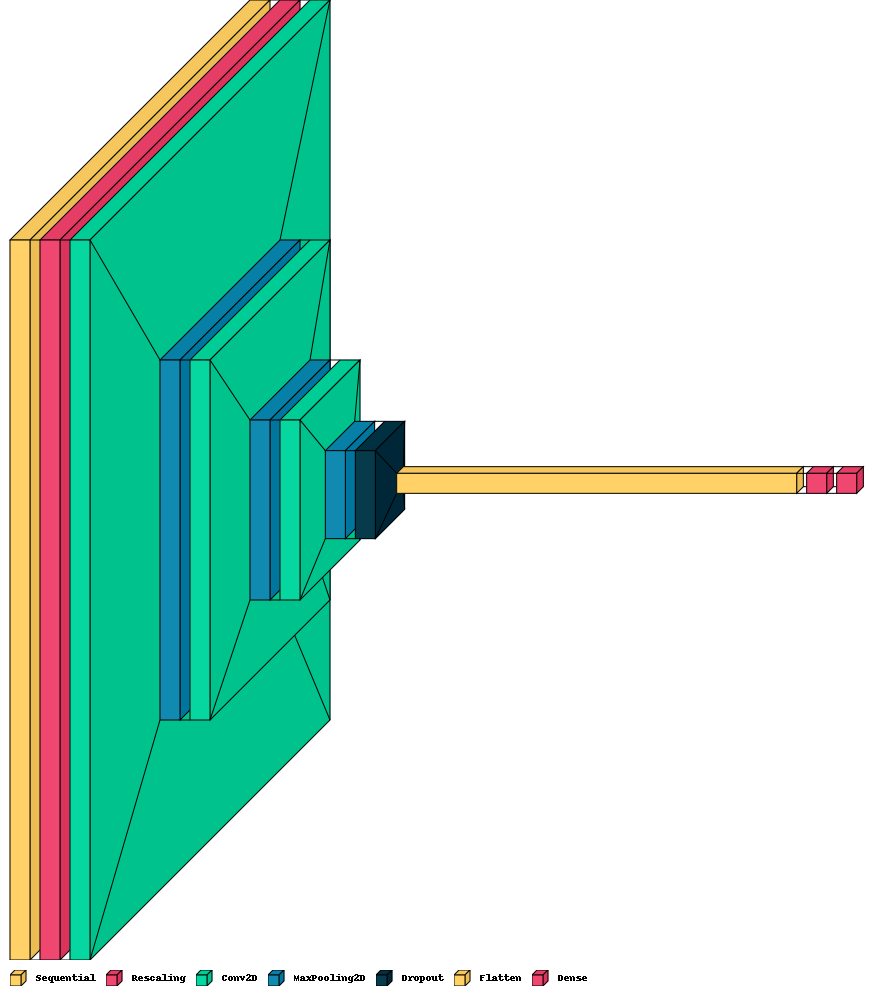

In [ ]:
! pip install visualkeras

import visualkeras
visualkeras.layered_view(model, legend=True)

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[Early_Stopping,learning_rate_reduction],
  epochs=epochs
)

Epoch 1/10
47/47 [==============================] - 63s 1s/step - loss: 0.7616 - accuracy: 0.5603 - val_loss: 0.6395 - val_accuracy: 0.6846 - lr: 0.0010
Epoch 2/10
47/47 [==============================] - 57s 1s/step - loss: 0.6281 - accuracy: 0.6626 - val_loss: 0.6367 - val_accuracy: 0.6792 - lr: 0.0010
Epoch 3/10
47/47 [==============================] - 55s 1s/step - loss: 0.6125 - accuracy: 0.6727 - val_loss: 0.5747 - val_accuracy: 0.6954 - lr: 0.0010
Epoch 4/10
47/47 [==============================] - 55s 1s/step - loss: 0.6066 - accuracy: 0.6795 - val_loss: 0.5978 - val_accuracy: 0.7089 - lr: 0.0010
Epoch 5/10
47/47 [==============================] - 54s 1s/step - loss: 0.5932 - accuracy: 0.6882 - val_loss: 0.5583 - val_accuracy: 0.7278 - lr: 0.0010
Epoch 6/10
47/47 [==============================] - 56s 1s/step - loss: 0.5837 - accuracy: 0.6963 - val_loss: 0.5797 - val_accuracy: 0.7332 - lr: 0.0010
Epoch 7/10
47/47 [==============================] - 56s 1s/step - loss: 0.5800 - a

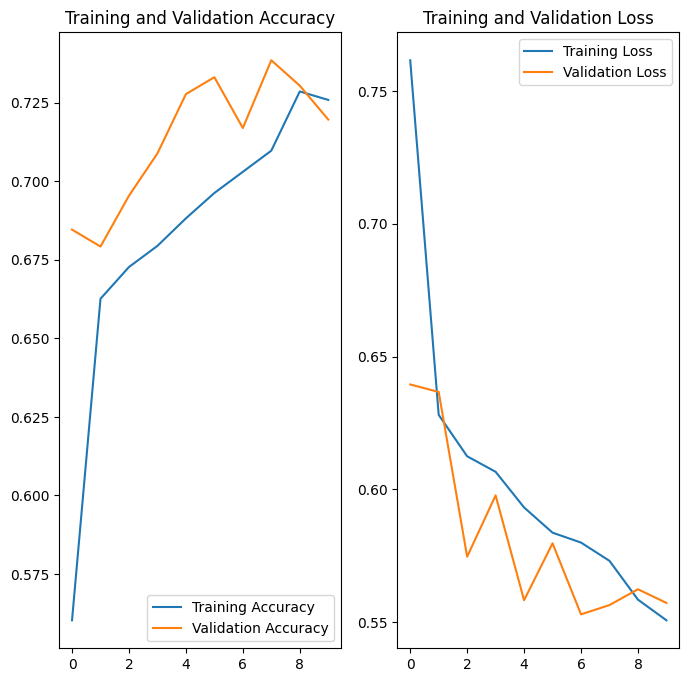

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

setelah dilakukan augmentasi dan drop out, terdapat hasil bahwa hasil akurasi validasi adalah 71% pada epoch 15

In [ ]:
x_val=[]
y_val=[]


for image, label in val_ds:
    x_val.extend(image.numpy())
    y_val.extend(label.numpy())

In [ ]:
loss, accuracy=model.evaluate(val_ds)
print(f"Accuracy:{accuracy}")
print(f"Loss:{loss}")

12/12 [==============================] - 3s 275ms/step - loss: 0.5573 - accuracy: 0.7197
Accuracy:0.7196765542030334
Loss:0.5572823286056519


In [ ]:
preds=model.predict(np.array(x_val))
y_pred = np.argmax(preds, axis=1)
print(y_pred)

12/12 [==============================] - 5s 430ms/step
[1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1
 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 0 1 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 1
 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 1
 0 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0 0 1 1 0 0
 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0
 1]


In [ ]:
plt.figure(figsize=(35, 35),tight_layout=True, facecolor="white")


for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(x_val[i].astype("uint8"))
    actual_label = class_names[y_val[i]]
    predicted_label = class_names[y_pred[i]]

    # Check if the actual and predicted labels are the same
    if actual_label == predicted_label:
        label_color ='green'
    else:
        label_color = 'red'


    plt.title(f'Actual: {actual_label} \n Predicted: {predicted_label}', color=label_color,fontsize=20)
    plt.axis("off")

plt.show()

F1-Score:[0.7049069995105237]
Precision:[0.7023809523809523]
Recall:[0.720811281786498]
Classification_Report
-----------------------
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       210
           1       0.72      0.57      0.64       161

    accuracy                           0.72       371
   macro avg       0.72      0.70      0.70       371
weighted avg       0.72      0.72      0.71       371

Confusion_Matrix
----------------------


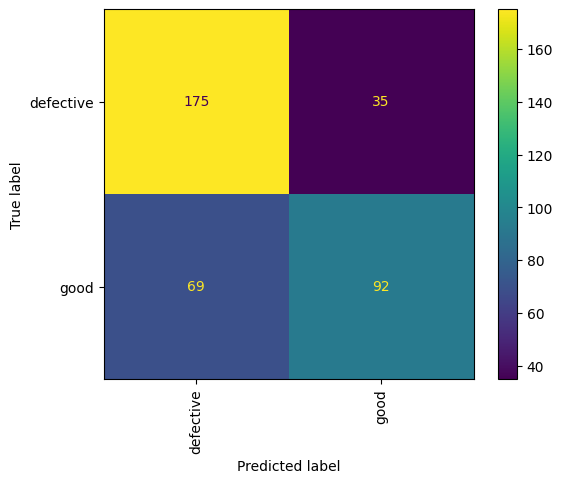

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay,classification_report

f1_scores=[]
precision_scores=[]
recall_scores=[]

f1_scores.append(f1_score(y_pred, y_val, average="macro"))
precision_scores.append(precision_score(y_pred, y_val, average="macro"))
recall_scores.append(recall_score(y_pred, y_val, average="macro"))


# Print the Results
print(f"F1-Score:{f1_scores}")
print(f"Precision:{precision_scores}")
print(f"Recall:{recall_scores}")



print("Classification_Report")
print("-----------------------")
print(classification_report(y_val,y_pred))
print("Confusion_Matrix")
print("----------------------")
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=class_names, xticks_rotation="vertical")
plt.show()

# **Percobaan model dengan gambar**

1/1 [==============================] - 0s 72ms/step
This image most likely belongs to defective with a 67.13 percent confidence.


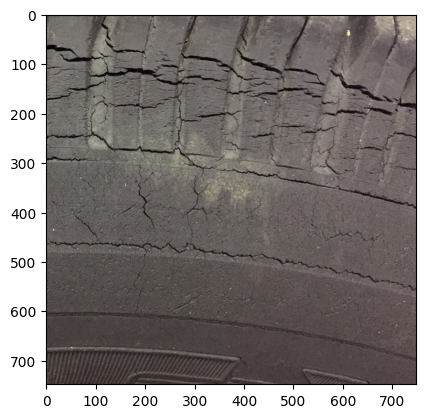

In [ ]:
base_dirr = "/content/Digital images of defective and good condition tyres/defective/Defective (1).jpg"

img = tf.keras.utils.load_img(
    base_dirr, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
im = Image.open(base_dirr)
plt.imshow(im)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 87ms/step
This image most likely belongs to good with a 68.83 percent confidence.


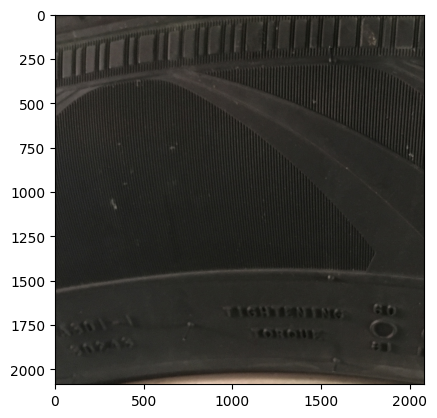

In [ ]:
base_dirr = "/content/Digital images of defective and good condition tyres/good/good (1).jpg"

img = tf.keras.utils.load_img(
    base_dirr, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
im = Image.open(base_dirr)
plt.imshow(im)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
from tensorflow.keras.models import save_model

save_model(model, 'ban.h5')
print("Model Saved")

Model Saved


<ipython-input-43-a62f54537e63>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'ban.h5')
